In [48]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
from plotly.offline import *
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import random

In [57]:
repo = ('https://raw.githubusercontent.com/PolarSprings/Iowa_advanced_regression/main/model_selec_dim.csv?token=AKXGRRTFSDYTOOXF5CLCQJDA4OZCE')

models3 = pd.read_csv(repo, skipinitialspace=True)

In [58]:
models3[:5]

,GrLivArea,QualScore,HouseAge,GarageScore,AllBaths,RoomScore,Details,Impress,Location,Years,Fundamentals,AdjSalePrice
0,856,5136,67.333333,798.0,2.0,4,254,6,0.393249,8.516526,0.855140,116167.600998
1,1049,5245,25.000000,266.0,3.0,25,328,36,0.287984,7.624843,0.855140,127628.236908
2,1001,5005,51.333333,216.0,1.0,20,328,8,0.225342,-4.535572,0.855140,117820.879800
3,1039,4156,74.666667,281.0,1.0,30,326,24,0.261238,7.624843,0.855140,104624.139651
4,1665,13320,8.000000,1056.0,4.0,120,328,40,0.395304,7.624843,-1.462448,208362.224439


In [59]:

def ScoreBaseModel(model, df, dependent, n):
    
    train_score_lst = []
    test_score_lst = []
    
    for i in range(1,n+1):    
        
        random.seed(42)
  
        data = df.drop([dependent], 1)
        target = df[[dependent]].squeeze()
        
        idx = np.random.choice(range(0,len(models3)), size=round(len(models3)*0.75), replace=False)
        
        x_train = data.iloc[idx]
        y_train = target.iloc[idx]
        
        x_test = data.iloc[~idx]
        y_test = target.iloc[~idx]
             
        clf = model
                
        clf.fit(x_train, y_train.squeeze()) 
        
        train_score_lst.append(clf.score(x_train, y_train))
        test_score_lst.append(clf.score(x_test, y_test))
        
    return train_score_lst, test_score_lst

tree_train, tree_test = ScoreBaseModel(DecisionTreeRegressor(), models3, 'AdjSalePrice',30)
rf_train, rf_test     = ScoreBaseModel(RandomForestRegressor(), models3, 'AdjSalePrice',30)
lr_train, lr_test     = ScoreBaseModel(LinearRegression(), models3, 'AdjSalePrice',30)
xgb_train, xgb_test   = ScoreBaseModel(XGBRegressor(), models3, 'AdjSalePrice',30)

In [52]:
import plotly.figure_factory as ff

model_names = ['Linear Regression','Decision Tree','Random Forest','Extreme Gradient Boosting']

train_scores = [lr_train,tree_train, rf_train, xgb_train]
test_scores = [lr_test,tree_test, rf_test, xgb_test]

scores_dict = dict(zip(model_names, test_scores))

data = scores_dict.values()
cols = scores_dict.keys()

fig = ff.create_distplot([i for i in data], [j for j in cols], bin_size=0.01)
fig.update_layout({'title':{'text':'Accuracy Scores, n=30'}, 'xaxis':{'title':{'text':'Accuracy'}}, 'yaxis':{'title':{'text':'Distribution'}}},xaxis_range=[0.88,1])


iplot(fig)

In [60]:
# For feature importances

random.seed(42)

data = models3.drop(['AdjSalePrice'], 1)
target = models3[['AdjSalePrice']].squeeze()

idx = np.random.choice(range(0,len(models3)), size=round(len(models3)*0.75), replace=False)

x_train = data.iloc[idx]
y_train = target.iloc[idx]

x_test = data.iloc[~idx]
y_test = target.iloc[~idx]

xgbooster = XGBRegressor()

xgbooster.fit(x_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
print(xgbooster.feature_importances_)
print(xgbooster.get_booster().get_fscore())

[0.0101069  0.62715673 0.03902362 0.02649589 0.0433079  0.01361173
 0.12763712 0.05867876 0.02323677 0.01788668 0.01285781]
{'QualScore': 657, 'Details': 213, 'GrLivArea': 906, 'Impress': 200, 'AllBaths': 126, 'HouseAge': 566, 'GarageScore': 605, 'RoomScore': 290, 'Location': 302, 'Fundamentals': 59, 'Years': 201}


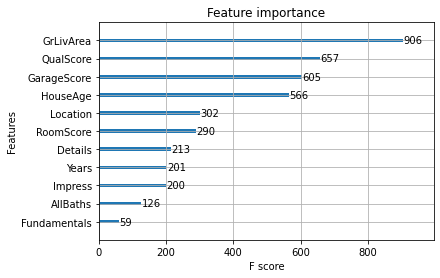

In [65]:
from xgboost import plot_importance

plot_importance(xgbooster)
plt.show()